<a href="https://colab.research.google.com/github/damladmrk/YZABootcamp/blob/main/BootcampDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

In [2]:
def check_df(dataframe, head=5):
    """

    It gives an overview for a data about it's columns, their quantiles etc.

    Parameters
    ------
        dataframe: dataframe
                Dataframe that will be analyzed.
        head=5: int, optional
                numeric threshold to be set for categoric variables
    Returns
    ------
        None

    """
    print("______________ Shape ______________") # Removed extra space before this line
    print(dataframe.shape)
    print("______________ Types ______________")
    print(dataframe.dtypes)
    print("______________ Head ______________")
    print(dataframe.head(head))
    print("______________ Tail ______________")
    print(dataframe.tail(head))
    print("______________ Nulls ______________")
    print(dataframe.isnull().sum())
    print("______________ Quantiles ______________")
    # Sadece sayısal kolonları al ve onların quantile'larını yazdır
    num_df = dataframe.select_dtypes(include=["int64", "float64"])
    if not num_df.empty:
        print(num_df.quantile([0, 0.25, 0.50, 0.75, 0.99, 1]).T)
    else:
        print("No numeric columns available for quantile analysis.")
    print("______________ Bools&Obj ______________")
    print(dataframe.describe(include=["object", "bool"]))

In [3]:
def column_names(dataframe, cat_th=10, car_th=20):
    """

    It seperates the columns to their types as categorical and cardinal.
    Note: It holds numeric variables in the categorical part if they are under the treshold.

    Parameters
    ------
        dataframe: dataframe
                Dataframe that will be analyzed.
        cat_th: int, optional
                numeric threshold to be set for categoric variables
        car_th: int, optional
                numeric threshold to be set for cardinal variables
    Returns
    ------
        cat_cols: list
                Categoric variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categoric to cardinal variable list

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total variable list
        num_but_cat is in cat_cols

    """
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [4]:
def cat_summ(dataframe, plot=False):
  """
      It gives an overview in categoric columns in a given dataframe.

      Parameters
      ------
          dataframe: dataframe
                  Dataframe that will be analyzed.
          plot=False: bool, optional
                  numeric threshold to be set for categoric variables
      Returns
      ------
          None
  """
  cat_cols, num_cols, cat_but_car = column_names(dataframe)
  for col_name in cat_cols:
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(sort=True),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("__________________________")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [5]:
def num_summ(dataframe, plot=False):
  """
      It gives an overview in numeric columns in a given dataframe.

      Parameters
      ------
          dataframe: dataframe
                  Dataframe that will be analyzed.
          plot=False: bool, optional
                  numeric threshold to be set for numeric variables
      Returns
      ------
          None
  """
  quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
  cat_cols, num_cols, cat_but_car = column_names(dataframe)
  for col_name in num_cols:
      print(dataframe[col_name].describe(quantiles).T)

      if plot:
          dataframe[col_name].hist(bins=20)
          plt.xlabel(col_name)
          plt.title(col_name)
          plt.show()

In [6]:
def corr_matrix(dataframe, plot=False):
  """
      It shows correlations of variables in a given dataframe.

      Parameters
      ------
          dataframe: dataframe
                  Dataframe that will be analyzed.
          plot=False: bool, optional
                  if True, it plots the heatmap
      Returns
      ------
          None
  """
  print(dataframe.corr())
  if plot:
    f, ax = plt.subplots(figsize=[8, 5])
    sns.heatmap(dataframe.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
    ax.set_title("Correlation Matrix", fontsize=10)
    plt.show()

In [7]:
def replace_outliers_with_limits(dataframe, column_name, q1= 0.2, q3= 0.8):
    """
    Replace outliers in a column with the upper and lower limits by using IQR approach.

    Parameters:
    ------
        dataframe : pd.DataFrame
            dataframe (pandas DataFrame).

        column_name : str
            target column to change.

        q1 : float, default= 0.2
            quantile for lower limit.

        q3 : float, default= 0.8
            quantile for upper limit.

    Returns:
    ------
        pd.DataFrame
            Dataframe with outliers replaced.

        float
            ratio of values lies outside the lower limit.

        float
            ratio of values lies outside the upper limit.
    """

    Q1 = dataframe[column_name].quantile(q1)
    Q3 = dataframe[column_name].quantile(q3)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    lower_outliers = dataframe[column_name] < lower_bound
    upper_outliers = dataframe[column_name] > upper_bound
    lower_outlier_ratio = lower_outliers.sum() / len(dataframe)
    upper_outlier_ratio = upper_outliers.sum() / len(dataframe)

    dataframe[column_name] = np.where(dataframe[column_name] < lower_bound, lower_bound, dataframe[column_name])
    dataframe[column_name] = np.where(dataframe[column_name] > upper_bound, upper_bound, dataframe[column_name])

    return (
        dataframe,
        f"Ratio of values less than lower limit: {lower_outlier_ratio:.4f}",
        f"Ratio of values greater than upper limit: {upper_outlier_ratio:.4f}"
    )

In [8]:
def plot_distribution(dataframe, column_name, plot= True):
  """
    Plots the distribution of a column in a given dataframe.

    Parameters
    ------
        dataframe: pd.DataFrame
            The dataframe containing the column to be plotted.

        column_name: str
            The name of the column to be plotted.

        plot: bool, optional
            If True, plots the distribution of the column.

    Returns
    ------
        dist_df: pd.DataFrame
            A dataframe containing the counts and percentages of each unique value in the specified column.

        None
        If plot is True, displays the distribution plot.
  """
  counts= dataframe[column_name].value(counts)
  percentages = 100 * dataframe[column_name].value_counts(normalize=True)

  dist_df = pd.DataFrame({column_name: counts, "Percentage": percentages})

  if plot:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=dist_df.index, y="Percentage", data=dist_df, palette="rocket")
        plt.title(f"Distribution of {column_name}")
        plt.ylabel("Percentage")
        plt.xlabel(column_name)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

  return dist_df

In [9]:
def binary_label_encoder(dataframe):
  """
    It transfers the binary object columns to numeric binary variables.

    Parameters
    ------
        dataframe: pd.DataFrame
            The dataframe containing the binary object columns to be encoded.

    Returns
    ------
        dataframe: pd.DataFrame
            The dataframe with the binary object columns encoded as numeric binary variables.
  """
  labelencoder = LabelEncoder()
  binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]

  for col in binary_cols:
    dataframe[col] = labelencoder.fit_transform(dataframe[col])

  return dataframe

In [10]:
from google.colab import files
files.upload()


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"damlademirok","key":"8cd0a87704a824fc0b860543eff78e6c"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [16]:
!kaggle datasets download -d cid007/mental-disorder-classification


Dataset URL: https://www.kaggle.com/datasets/cid007/mental-disorder-classification
License(s): CC0-1.0
  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 5.76MB/s]


In [17]:
!unzip -o mental-disorder-classification.zip


Archive:  mental-disorder-classification.zip
  inflating: Dataset-Mental-Disorders.csv  


In [18]:
df = pd.read_csv("Dataset-Mental-Disorders.csv")
df.head()

,Patient Number,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,Patiant-01,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,Patiant-02,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression
2,Patiant-03,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6 From 10,5 From 10,7 From 10,Bipolar Type-1
3,Patiant-04,Usually,Seldom,Usually,Most-Often,YES,YES,YES,NO,YES,NO,NO,NO,NO,NO,3 From 10,2 From 10,2 From 10,Bipolar Type-2
4,Patiant-05,Usually,Usually,Sometimes,Sometimes,NO,NO,NO,NO,NO,NO,NO,YES,YES,YES,5 From 10,5 From 10,6 From 10,Normal


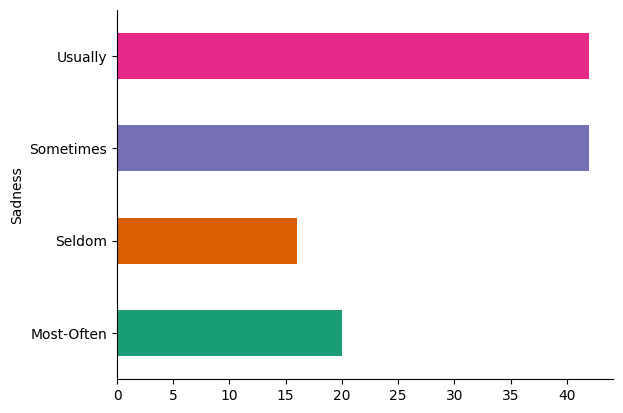

In [19]:
# @title Sadness

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sadness').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [20]:
# Genel kontrol
check_df(df)

# Kategorik ve sayısal değişkenleri listele
cat_cols, num_cols, cat_but_car = column_names(df)

______________ Shape ______________
(120, 19)
______________ Types ______________
Patient Number         object
Sadness                object
Euphoric               object
Exhausted              object
Sleep dissorder        object
Mood Swing             object
Suicidal thoughts      object
Anorxia                object
Authority Respect      object
Try-Explanation        object
Aggressive Response    object
Ignore & Move-On       object
Nervous Break-down     object
Admit Mistakes         object
Overthinking           object
Sexual Activity        object
Concentration          object
Optimisim              object
Expert Diagnose        object
dtype: object
______________ Head ______________
  Patient Number    Sadness    Euphoric  Exhausted Sleep dissorder Mood Swing  \
0     Patiant-01    Usually      Seldom  Sometimes       Sometimes        YES   
1     Patiant-02    Usually      Seldom    Usually       Sometimes         NO   
2     Patiant-03  Sometimes  Most-Often  Sometimes      

Observations: 120
Variables: 19
cat_cols: 18
num_cols: 0
cat_but_car: 1
num_but_cat: 0
            Sadness      Ratio
Sadness                       
Usually          42  35.000000
Sometimes        42  35.000000
Most-Often       20  16.666667
Seldom           16  13.333333
__________________________


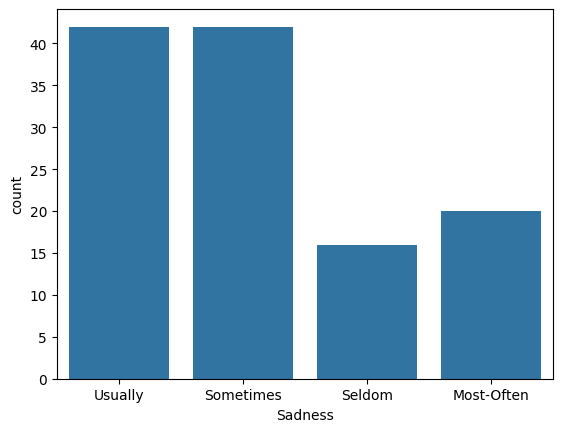

            Euphoric      Ratio
Euphoric                       
Seldom            46  38.333333
Sometimes         45  37.500000
Usually           20  16.666667
Most-Often         9   7.500000
__________________________


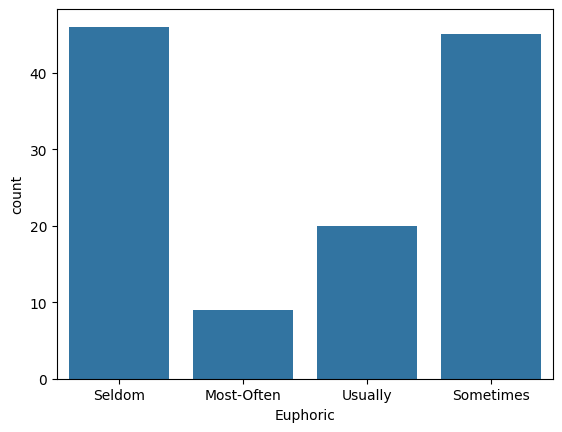

            Exhausted      Ratio
Exhausted                       
Sometimes          38  31.666667
Usually            34  28.333333
Most-Often         30  25.000000
Seldom             18  15.000000
__________________________


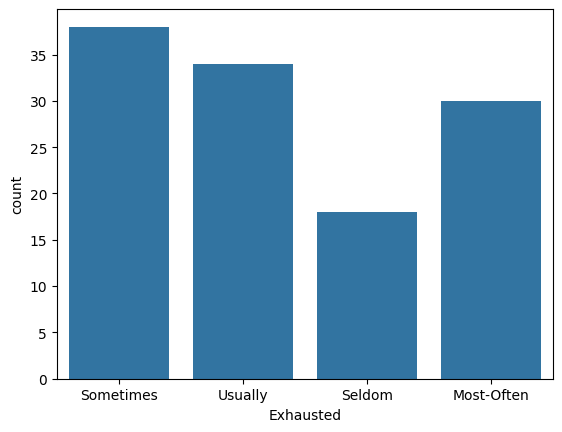

                 Sleep dissorder      Ratio
Sleep dissorder                            
Sometimes                     44  36.666667
Usually                       34  28.333333
Most-Often                    21  17.500000
Seldom                        21  17.500000
__________________________


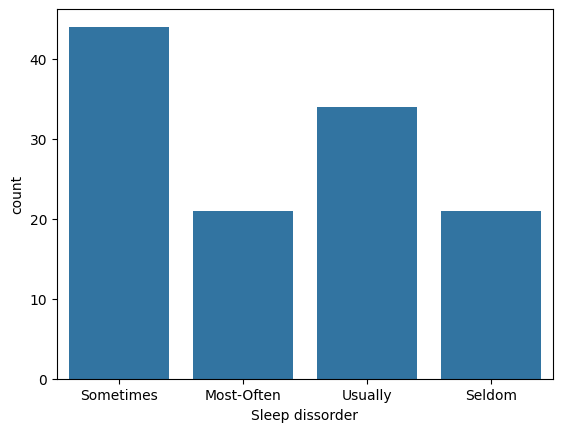

            Mood Swing  Ratio
Mood Swing                   
NO                  63   52.5
YES                 57   47.5
__________________________


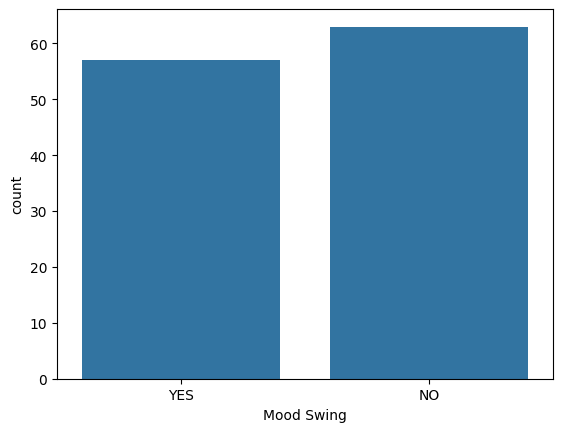

                   Suicidal thoughts      Ratio
Suicidal thoughts                              
NO                                63  52.500000
YES                               56  46.666667
YES                                1   0.833333
__________________________


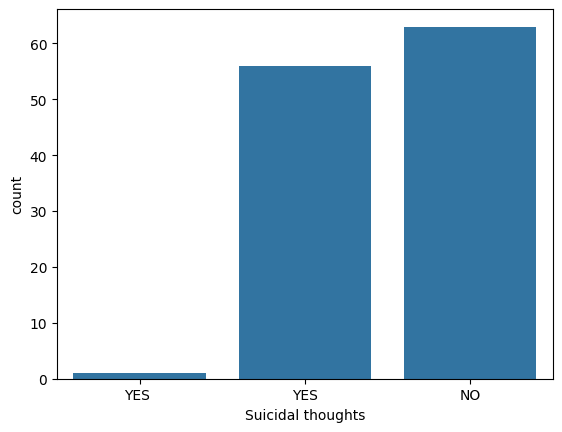

         Anorxia      Ratio
Anorxia                    
NO            74  61.666667
YES           46  38.333333
__________________________


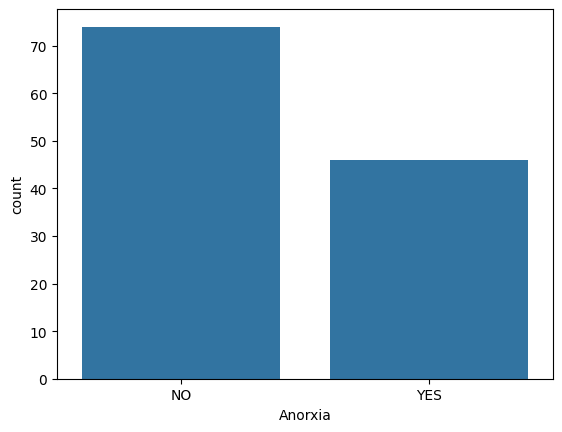

                   Authority Respect      Ratio
Authority Respect                              
NO                                73  60.833333
YES                               47  39.166667
__________________________


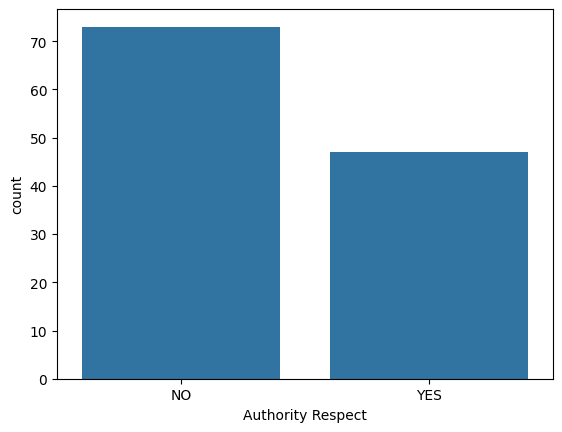

                 Try-Explanation  Ratio
Try-Explanation                        
NO                            63   52.5
YES                           57   47.5
__________________________


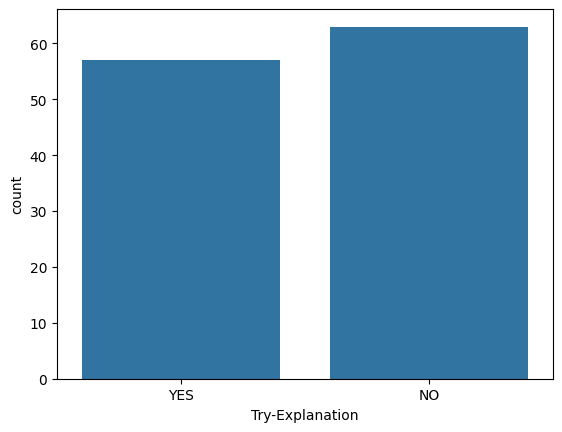

                     Aggressive Response      Ratio
Aggressive Response                                
NO                                    62  51.666667
YES                                   58  48.333333
__________________________


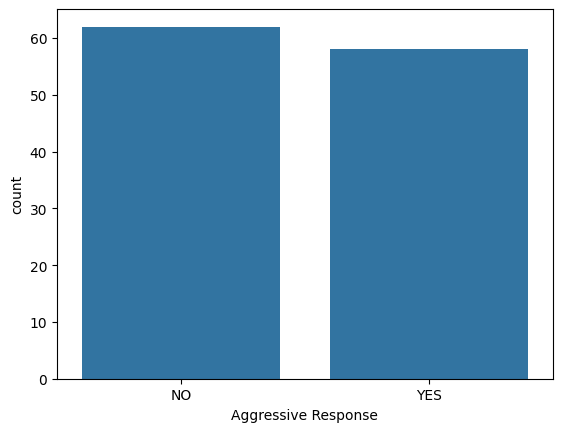

                  Ignore & Move-On      Ratio
Ignore & Move-On                             
NO                              70  58.333333
YES                             50  41.666667
__________________________


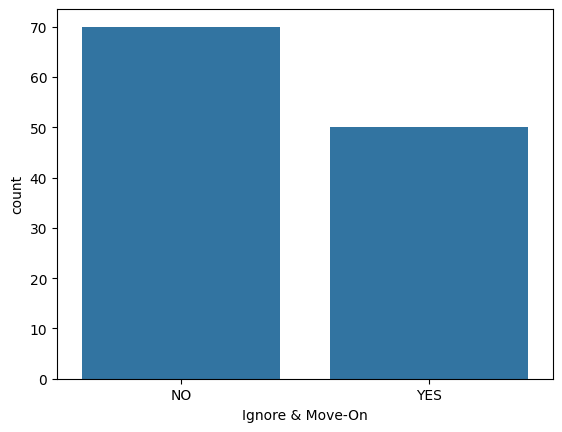

                    Nervous Break-down      Ratio
Nervous Break-down                               
YES                                 62  51.666667
NO                                  58  48.333333
__________________________


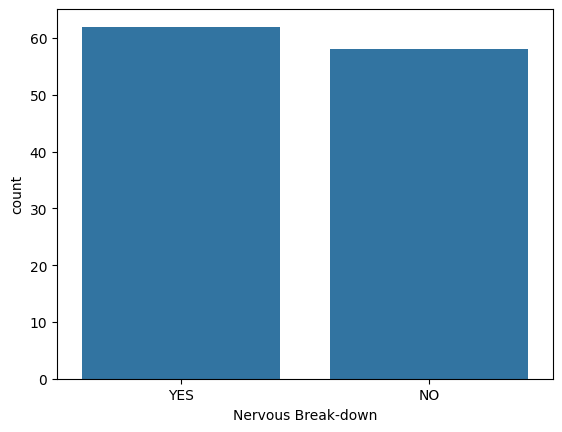

                Admit Mistakes      Ratio
Admit Mistakes                           
NO                          61  50.833333
YES                         59  49.166667
__________________________


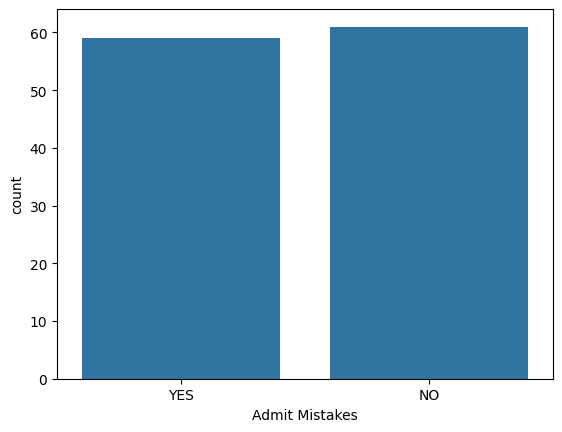

              Overthinking      Ratio
Overthinking                         
YES                     65  54.166667
NO                      55  45.833333
__________________________


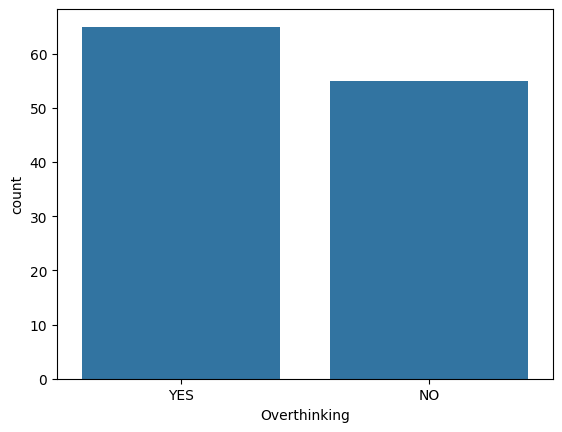

                 Sexual Activity      Ratio
Sexual Activity                            
5 From 10                     22  18.333333
4 From 10                     20  16.666667
3 From 10                     17  14.166667
6 From 10                     15  12.500000
2 From 10                     15  12.500000
7 From 10                     14  11.666667
8 From 10                     11   9.166667
1 From 10                      4   3.333333
9 From 10                      2   1.666667
__________________________


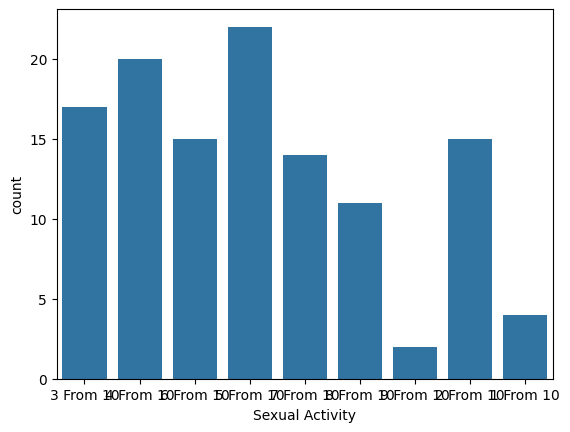

               Concentration      Ratio
Concentration                          
4 From 10                 33  27.500000
2 From 10                 21  17.500000
5 From 10                 21  17.500000
7 From 10                 14  11.666667
3 From 10                 12  10.000000
6 From 10                 10   8.333333
1 From 10                  5   4.166667
8 From 10                  4   3.333333
__________________________


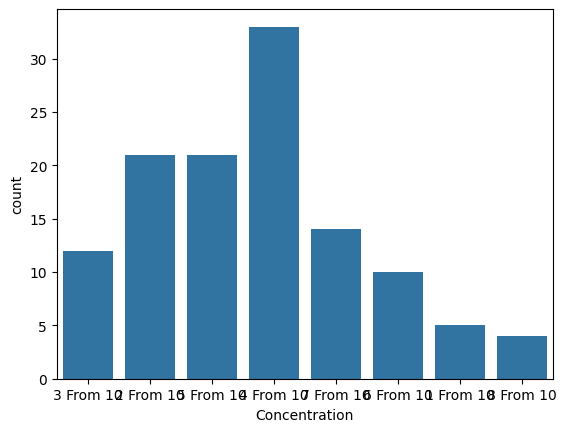

           Optimisim      Ratio
Optimisim                      
6 From 10         21  17.500000
5 From 10         20  16.666667
4 From 10         19  15.833333
2 From 10         18  15.000000
3 From 10         18  15.000000
7 From 10          8   6.666667
8 From 10          8   6.666667
1 From 10          6   5.000000
9 From 10          2   1.666667
__________________________


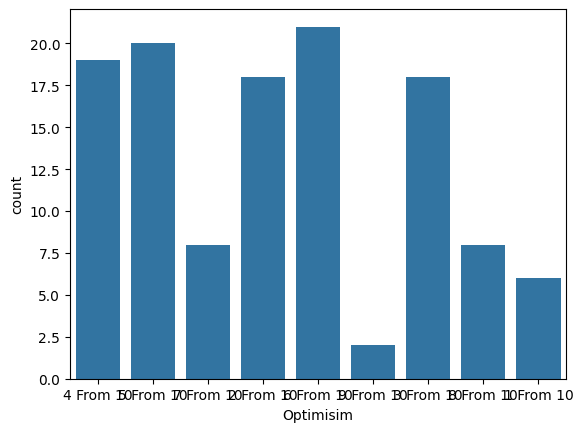

                 Expert Diagnose      Ratio
Expert Diagnose                            
Bipolar Type-2                31  25.833333
Depression                    31  25.833333
Normal                        30  25.000000
Bipolar Type-1                28  23.333333
__________________________


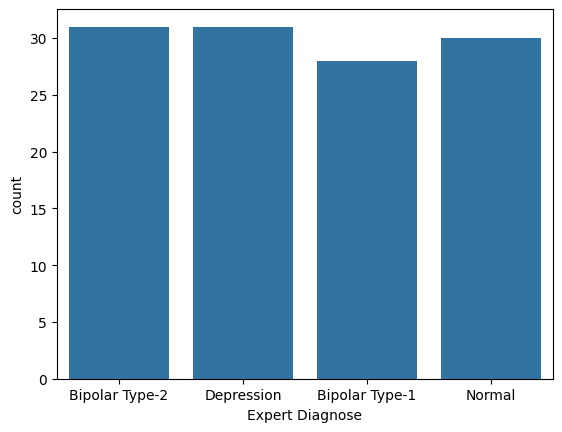

In [21]:
# Kategorik değişkenleri özetle ve plotla
cat_summ(df, plot=True)


In [22]:
df['Patient Number'] = df['Patient Number'].astype(str).str.extract('(\d+)')
df.head()

,Patient Number,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,01,Usually,Seldom,Sometimes,Sometimes,YES,YES,NO,NO,YES,NO,NO,YES,YES,YES,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,02,Usually,Seldom,Usually,Sometimes,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,4 From 10,2 From 10,5 From 10,Depression
2,03,Sometimes,Most-Often,Sometimes,Sometimes,YES,NO,NO,NO,YES,YES,NO,YES,YES,NO,6 From 10,5 From 10,7 From 10,Bipolar Type-1
3,04,Usually,Seldom,Usually,Most-Often,YES,YES,YES,NO,YES,NO,NO,NO,NO,NO,3 From 10,2 From 10,2 From 10,Bipolar Type-2
4,05,Usually,Usually,Sometimes,Sometimes,NO,NO,NO,NO,NO,NO,NO,YES,YES,YES,5 From 10,5 From 10,6 From 10,Normal


In [23]:
print(df['Suicidal thoughts'].unique())

df['Suicidal thoughts'] = df['Suicidal thoughts'].str.strip().str.upper()

print(df['Suicidal thoughts'].unique())


['YES ' 'YES' 'NO']
['YES' 'NO']


In [24]:
yes_no_cols = ['Suicidal thoughts', 'Anorxia', 'Authority Respect',
               'Try-Explanation', 'Aggressive Response', 'Ignore & Move-On',
               'Nervous Break-down', 'Admit Mistakes', 'Overthinking', 'Mood Swing']

for col in yes_no_cols:
    df[col] = df[col].str.strip().str.upper().map({'YES': 1, 'NO': 0})


In [25]:
df.head()

,Patient Number,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,01,Usually,Seldom,Sometimes,Sometimes,1,1,0,0,1,0,0,1,1,1,3 From 10,3 From 10,4 From 10,Bipolar Type-2
1,02,Usually,Seldom,Usually,Sometimes,0,1,0,0,0,0,0,0,0,0,4 From 10,2 From 10,5 From 10,Depression
2,03,Sometimes,Most-Often,Sometimes,Sometimes,1,0,0,0,1,1,0,1,1,0,6 From 10,5 From 10,7 From 10,Bipolar Type-1
3,04,Usually,Seldom,Usually,Most-Often,1,1,1,0,1,0,0,0,0,0,3 From 10,2 From 10,2 From 10,Bipolar Type-2
4,05,Usually,Usually,Sometimes,Sometimes,0,0,0,0,0,0,0,1,1,1,5 From 10,5 From 10,6 From 10,Normal


In [26]:
rating_cols = ["Sexual Activity", "Concentration", "Optimisim"]

for col in rating_cols:
    df[col] = df[col].str.extract(r"(\d+)").astype(float)

In [27]:
df.drop("Patient Number", axis=1, inplace=True)

In [32]:
le = LabelEncoder()

target = "Expert Diagnose"

for col in df.columns:
    if df[col].dtype == "O" and col != target:
        df[col] = le.fit_transform(df[col])

In [33]:
df.head()


,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,3,1,2,2,1,1,0,0,1,0,0,1,1,1,3.0,3.0,4.0,Bipolar Type-2
1,3,1,3,2,0,1,0,0,0,0,0,0,0,0,4.0,2.0,5.0,Depression
2,2,0,2,2,1,0,0,0,1,1,0,1,1,0,6.0,5.0,7.0,Bipolar Type-1
3,3,1,3,0,1,1,1,0,1,0,0,0,0,0,3.0,2.0,2.0,Bipolar Type-2
4,3,3,2,2,0,0,0,0,0,0,0,1,1,1,5.0,5.0,6.0,Normal


In [35]:
score_columns = ["Sexual Activity", "Concentration", "Optimisim"]

print("Mean Scores per Diagnosis:\n")
print(df.groupby("Expert Diagnose")[score_columns].mean().round(2))


Mean Scores per Diagnosis:

                 Sexual Activity  Concentration  Optimisim
Expert Diagnose                                           
Bipolar Type-1              6.54           3.82       6.21
Bipolar Type-2              3.42           3.42       3.23
Depression                  4.06           4.61       3.16
Normal                      5.13           5.13       5.47


In [36]:
binary_cols = [col for col in df.columns if df[col].dtype in [int] and col not in score_columns]

for col in binary_cols:
    print(f"\n{col} distribution by Diagnosis (%):")
    print((pd.crosstab(df["Expert Diagnose"], df[col], normalize='index') * 100).round(1))



Sadness distribution by Diagnosis (%):
Sadness             0     1     2     3
Expert Diagnose                        
Bipolar Type-1    0.0  32.1  42.9  25.0
Bipolar Type-2   25.8   3.2  19.4  51.6
Depression       38.7   0.0  12.9  48.4
Normal            0.0  20.0  66.7  13.3

Euphoric distribution by Diagnosis (%):
Euphoric            0     1     2     3
Expert Diagnose                        
Bipolar Type-1   17.9  25.0  25.0  32.1
Bipolar Type-2    0.0  51.6  48.4   0.0
Depression        0.0  61.3  38.7   0.0
Normal           13.3  13.3  36.7  36.7

Exhausted distribution by Diagnosis (%):
Exhausted           0     1     2     3
Expert Diagnose                        
Bipolar Type-1   17.9  25.0  39.3  17.9
Bipolar Type-2   32.3   9.7  32.3  25.8
Depression       41.9   9.7   3.2  45.2
Normal            6.7  16.7  53.3  23.3

Sleep dissorder distribution by Diagnosis (%):
Sleep dissorder     0     1     2     3
Expert Diagnose                        
Bipolar Type-1   21.4   7.1  

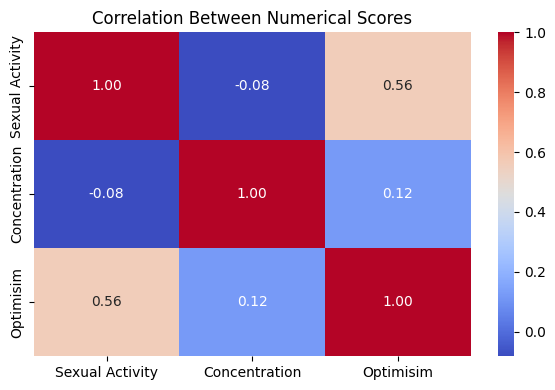

In [37]:
plt.figure(figsize=(6, 4))
sns.heatmap(df[score_columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numerical Scores")
plt.tight_layout()
plt.show()


In [45]:
df_org_target = df.copy()

le = LabelEncoder()
df["Expert Diagnose"] = le.fit_transform(df["Expert Diagnose"])
df.head()

,Sadness,Euphoric,Exhausted,Sleep dissorder,Mood Swing,Suicidal thoughts,Anorxia,Authority Respect,Try-Explanation,Aggressive Response,Ignore & Move-On,Nervous Break-down,Admit Mistakes,Overthinking,Sexual Activity,Concentration,Optimisim,Expert Diagnose
0,3,1,2,2,1,1,0,0,1,0,0,1,1,1,3.0,3.0,4.0,1
1,3,1,3,2,0,1,0,0,0,0,0,0,0,0,4.0,2.0,5.0,2
2,2,0,2,2,1,0,0,0,1,1,0,1,1,0,6.0,5.0,7.0,0
3,3,1,3,0,1,1,1,0,1,0,0,0,0,0,3.0,2.0,2.0,1
4,3,3,2,2,0,0,0,0,0,0,0,1,1,1,5.0,5.0,6.0,3
